In [1]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import itertools
import pandas as pd
from hampel import hampel
import matplotlib.pyplot as plt

In [2]:
HOSTED_APP_URL = 'https://iotproject.eu.pythonanywhere.com'
API_PLANT_DATA = '/api/v1/plant_data'

df_orig = pd.read_json(HOSTED_APP_URL + API_PLANT_DATA)
df_orig

,bridge_id,creation_date,dht_humidity,dht_temperature,gateway_id,humidity_1,humidity_2,humidity_3,id,last_modified,luminosity_1,luminosity_2,plant_id,plant_type_id,temperature,timestamp
0,RASPBERRY001,2021-04-02T00:29:21,76,23,ARDUINO001,NaN,NaN,NaN,1,2021-04-01T22:29:21,12,11,c5a3b03d82944886bb1fdb30612d5c5d,1,24.47,1200549
1,RASPBERRY001,2021-04-02T00:39:22,80,23,ARDUINO001,NaN,NaN,NaN,2,2021-04-01T22:39:22,12,11,c5a3b03d82944886bb1fdb30612d5c5d,1,24.47,1800823
2,RASPBERRY001,2021-04-02T00:59:19,81,23,ARDUINO001,NaN,NaN,NaN,3,2021-04-01T22:59:20,13,11,c5a3b03d82944886bb1fdb30612d5c5d,1,24.29,3001370
3,RASPBERRY001,2021-04-01T22:46:47,71,24,ARDUINO001,NaN,NaN,NaN,4,2021-04-01T23:09:21,62,65,c5a3b03d82944886bb1fdb30612d5c5d,1,24.55,600275
4,RASPBERRY001,2021-04-01T22:56:43,74,23,ARDUINO001,NaN,NaN,NaN,5,2021-04-01T23:09:21,63,66,c5a3b03d82944886bb1fdb30612d5c5d,1,24.38,1200548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6778,RASPBERRY001,2021-05-25T23:38:52,93,20,ARDUINO001,936.0,938.0,955.0,6779,2021-05-25T21:38:52,63,61,43c311e2279f4dd2afce8bbcff62371d,1,22.43,560655676
6779,RASPBERRY001,2021-05-25T23:48:48,93,20,ARDUINO001,935.0,937.0,955.0,6780,2021-05-25T21:48:49,63,62,43c311e2279f4dd2afce8bbcff62371d,1,22.52,561255950
6780,RASPBERRY001,2021-05-25T23:58:49,93,20,ARDUINO001,935.0,937.0,954.0,6781,2021-05-25T21:58:50,63,61,43c311e2279f4dd2afce8bbcff62371d,1,22.17,561856224
6781,RASPBERRY001,2021-05-26T00:08:50,93,20,ARDUINO001,935.0,939.0,955.0,6782,2021-05-25T22:08:51,63,61,43c311e2279f4dd2afce8bbcff62371d,1,22.26,562456498


In [3]:
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = pd.to_datetime(df_orig['creation_date'])

<AxesSubplot:xlabel='ds'>

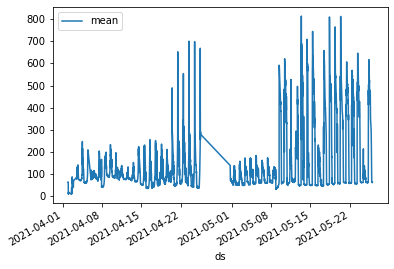

In [4]:
df['mean'] = df_orig[['luminosity_1', 'luminosity_2']].mean(axis=1)
df.plot(x='ds', y='mean')

<AxesSubplot:xlabel='ds'>

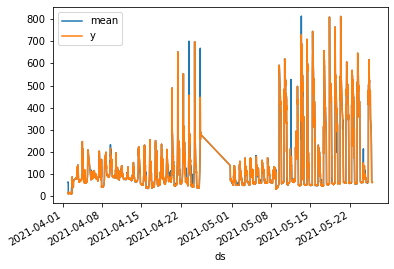

In [5]:
df['y'] = hampel(df['mean'], window_size=5, n=3, imputation=True)
df.plot(x='ds', y=['mean', 'y',])

In [6]:
m = Prophet()
m.fit(df)
periods = 2*24*60//10
future = m.make_future_dataframe(periods=periods, freq='10min')
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


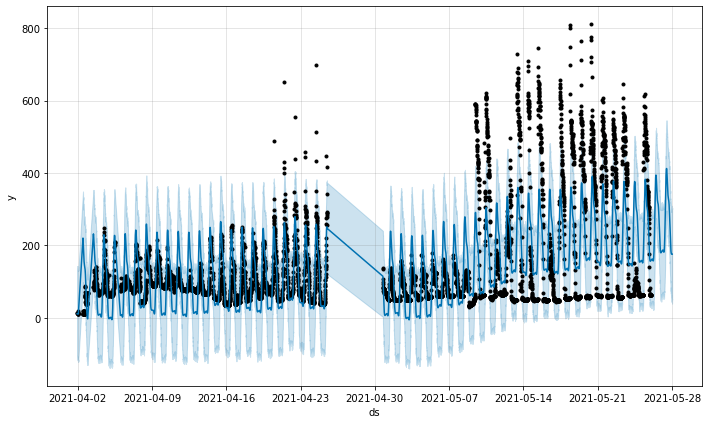

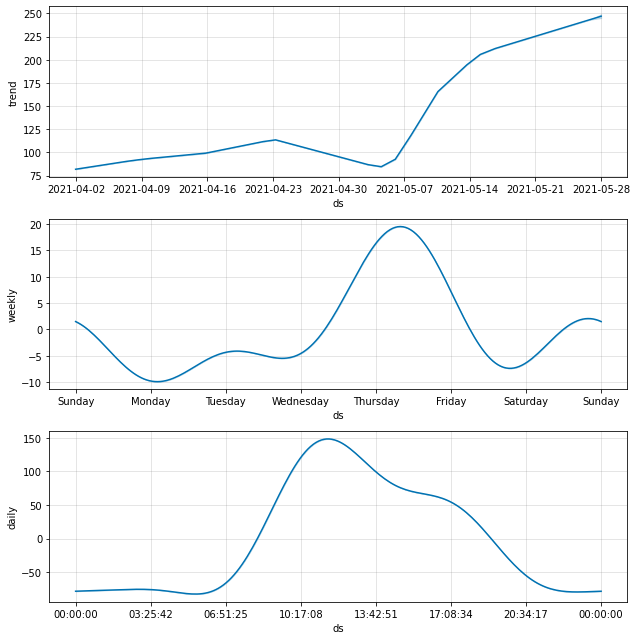

In [7]:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [8]:
#df_cv = cross_validation(m, horizon='48 hours')
#df_p = performance_metrics(df_cv)
#df_p

In [9]:
#fig3 = plot_cross_validation_metric(df_cv, metric='mape')

In [10]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param)
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

In [11]:
def single_cv_run(history_df, metrics, param_dict):
    mdl = Prophet(**param_dict)
    mdl.fit(history_df)
    df_cvl = cross_validation(mdl, horizon='48 hours')
    df_perf = performance_metrics(df_cvl).mean().to_frame().T
    df_perf['params'] = str(param_dict)
    df_perf = df_perf.loc[:, metrics]
    return df_perf

In [12]:
param_grid = {
                'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
                'changepoint_range': [0.8, 0.9],
                'seasonality_prior_scale':[0.1, 1, 10.0],
                #'holidays_prior_scale':[0.1, 1, 10.0],
                'seasonality_mode': ['multiplicative', 'additive'],
                #'growth': ['linear', 'logistic'],
                #'yearly_seasonality': [5, 10, 20]
              }
metrics = ['horizon', 'rmse', 'mape', 'params']
results = []
params_df = create_param_combinations(**param_grid)

In [13]:
# set var to True if you want to find hyper-params
find_hyper_params = False
if find_hyper_params:
    for param in params_df.values:
        param_dict = dict(zip(params_df.keys(), param))
        cv_df = single_cv_run(df,  metrics, param_dict)
        results.append(cv_df)
    results_df = pd.concat(results).reset_index(drop=True)
    best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
    print(f'\n The best param combination is {best_param.values[0][0]}')
    results_df

In [14]:
# The best param combination is
# {'changepoint_prior_scale': 0.005,
# 'changepoint_range': 0.9,
# 'seasonality_prior_scale': 0.1,
# 'seasonality_mode': 'additive'}
if find_hyper_params:
    results_df.to_csv('results_hyperparam_cv.csv')

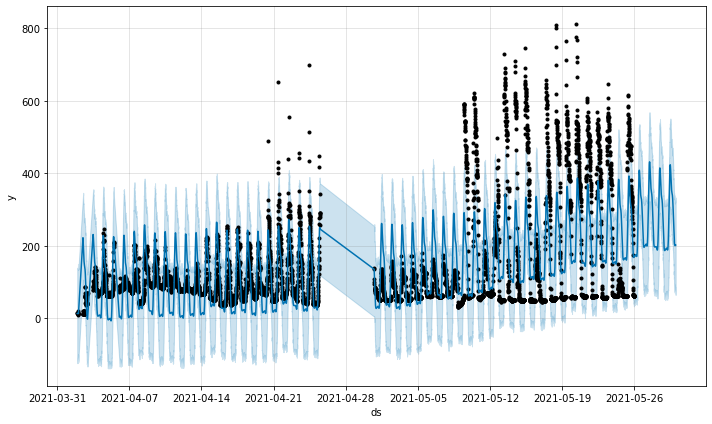

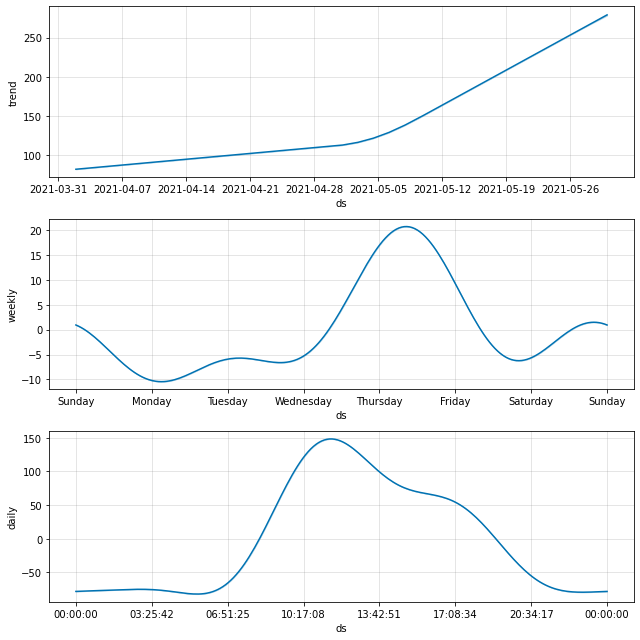

In [15]:
m = Prophet(
    growth='linear',
    yearly_seasonality=False,
    changepoint_prior_scale=0.005,
    changepoint_range=0.9,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive',
)
m.fit(df)
periods = 4*24*60//10
future = m.make_future_dataframe(periods=periods, freq='10min')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

<AxesSubplot:xlabel='ds'>

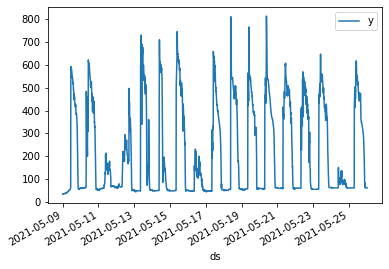

In [26]:
df2 = df[df['ds'] > pd.Timestamp('2021-05-09')]
df2.plot(x='ds', y=['y',])

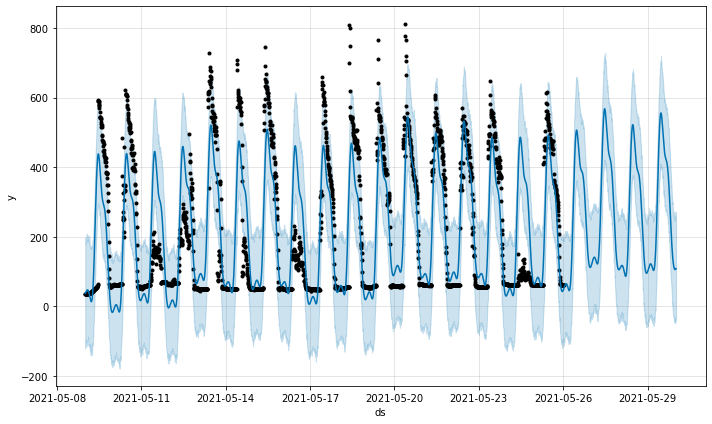

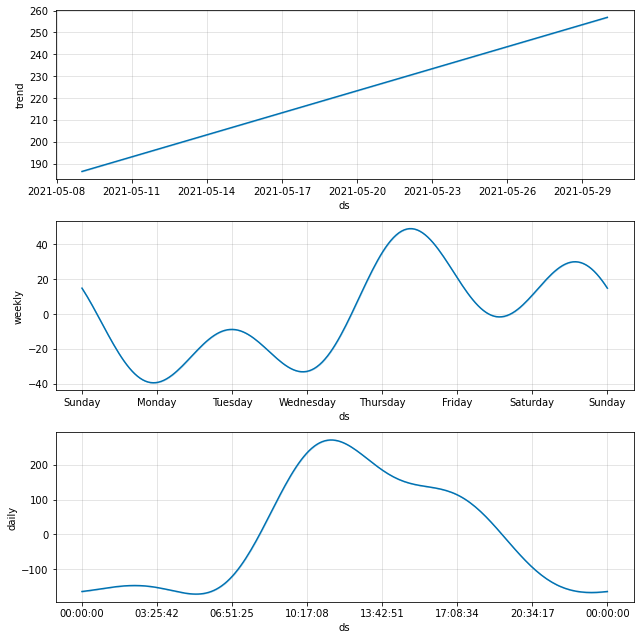

In [27]:
m = Prophet(
    growth='linear',
    yearly_seasonality=False,
    changepoint_prior_scale=0.005,
    changepoint_range=0.9,
    seasonality_prior_scale=0.1,
    seasonality_mode='additive',
)
m.fit(df2)
periods = 4*24*60//10
future = m.make_future_dataframe(periods=periods, freq='10min')
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)